In [45]:
import matplotlib
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
from skimage.transform import hough_ellipse
from matplotlib.patches import Ellipse, Circle
%matplotlib notebook

In [2]:
%connect_info

{
  "hb_port": 59493,
  "transport": "tcp",
  "shell_port": 59489,
  "ip": "127.0.0.1",
  "key": "990bb810-24b2-49ff-b426-0c86a6deaf5e",
  "iopub_port": 59490,
  "kernel_name": "",
  "control_port": 59492,
  "stdin_port": 59491,
  "signature_scheme": "hmac-sha256"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-4e1fbcfc-bebd-4140-b28f-4623b69ec2d0.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [3]:
f = '../sample-photos/Sun_with_one_AR.jpg'

In [4]:
# read in the image
im_rgb = matplotlib.image.imread(f)
# remove color info
im = np.average(im_rgb, axis=2)

<IPython.core.display.Javascript object>


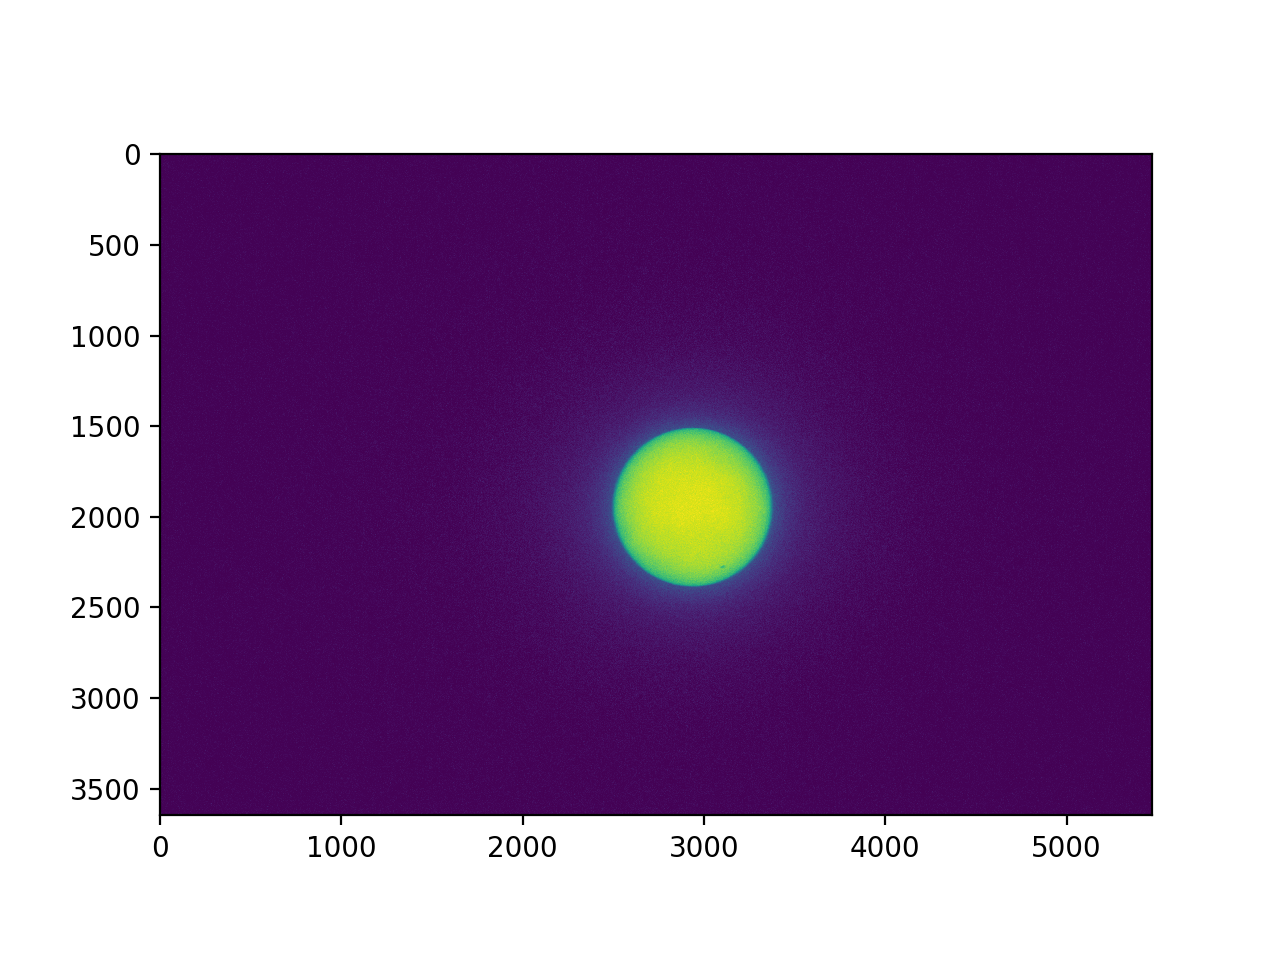

In [5]:
plt.imshow(im)

In [14]:
blur_im = ndimage.gaussian_filter(im, 8)

<IPython.core.display.Javascript object>


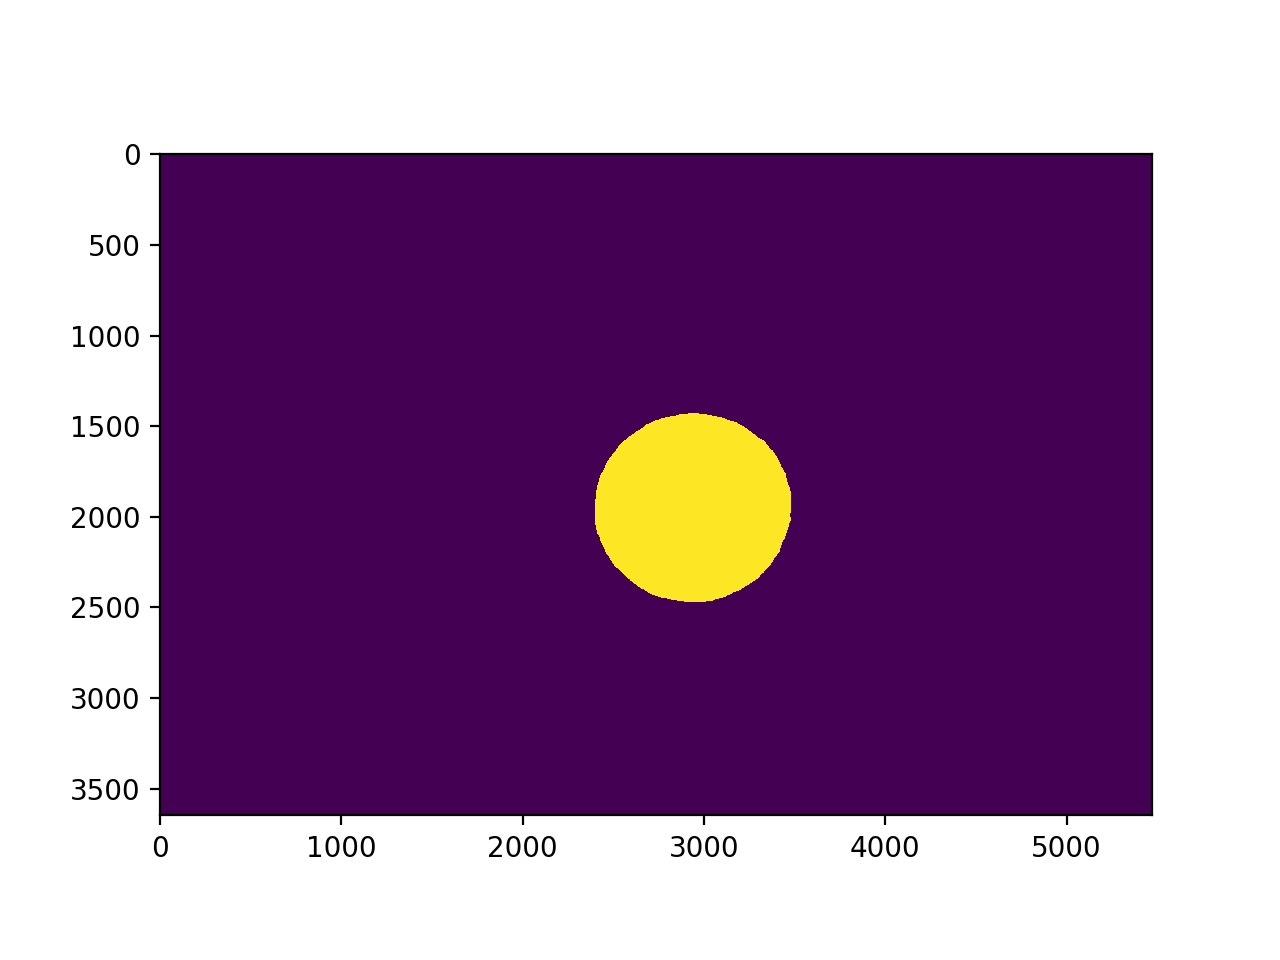

In [15]:
mask = blur_im > blur_im.mean() * 3
plt.imshow(mask)

In [16]:
label_im, nb_labels = ndimage.label(mask)

<IPython.core.display.Javascript object>


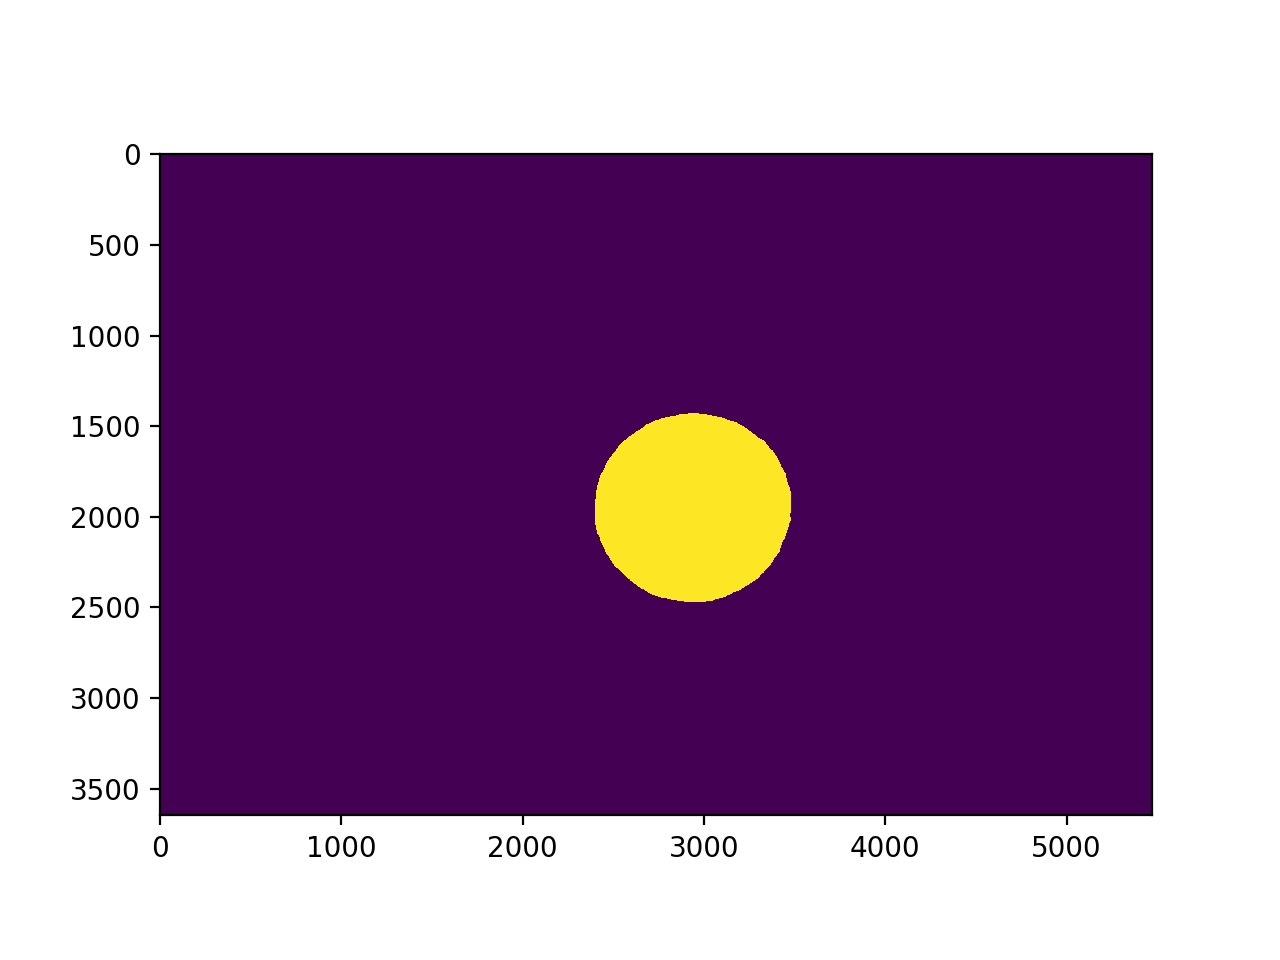

In [17]:
plt.imshow(label_im)

<IPython.core.display.Javascript object>


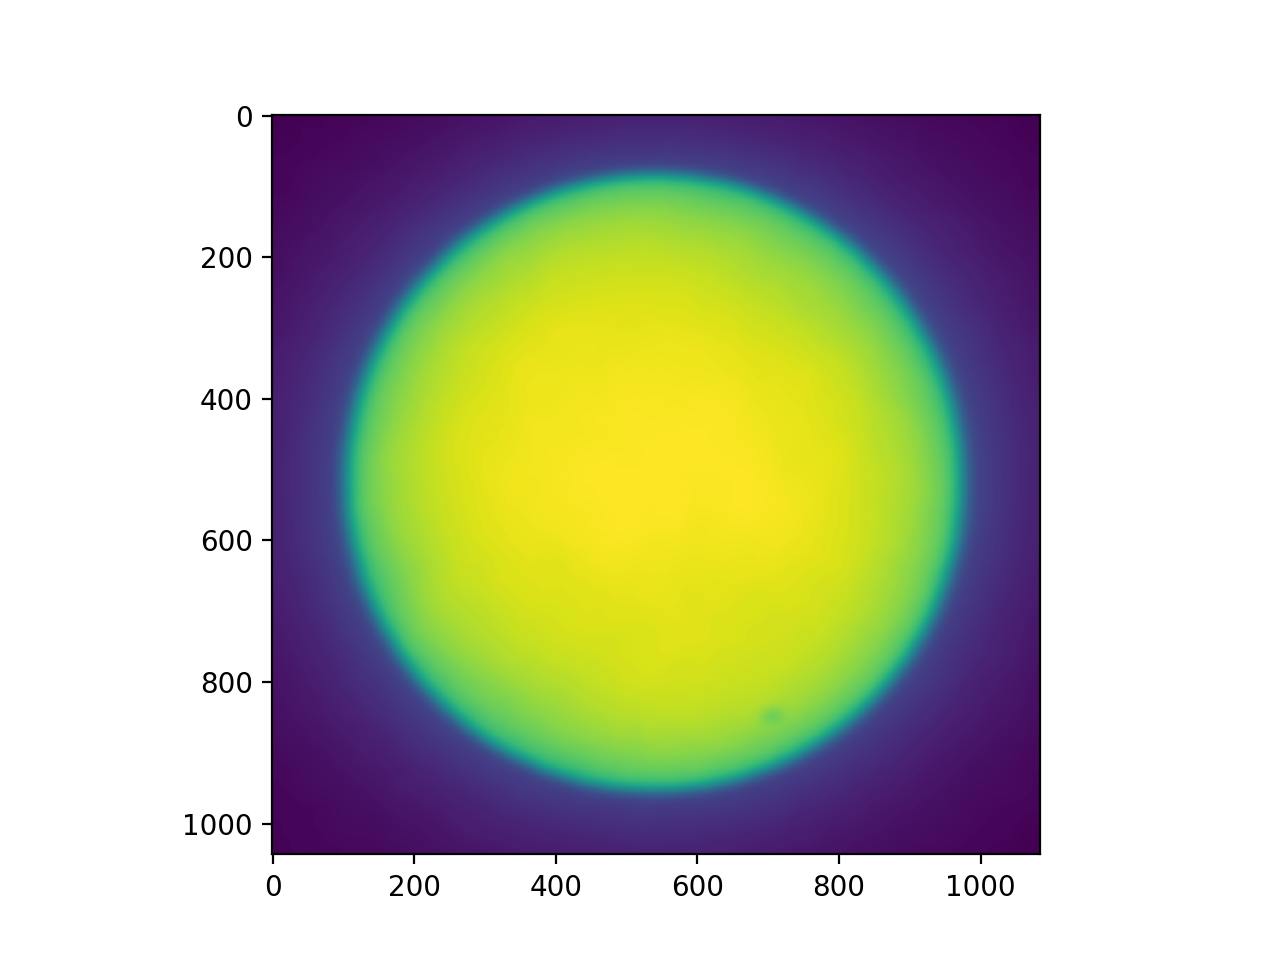

In [29]:
slice_x, slice_y = ndimage.find_objects(label_im==1)[0]
roi = blur_im[slice_x, slice_y]
plt.imshow(roi)     

In [30]:
sx = ndimage.sobel(roi, axis=0, mode='constant')
sy = ndimage.sobel(roi, axis=1, mode='constant')
sob = np.hypot(sx, sy)

In [58]:
downsample_dim = 4
working_sob = sob[::downsample_dim, ::downsample_dim]

<IPython.core.display.Javascript object>


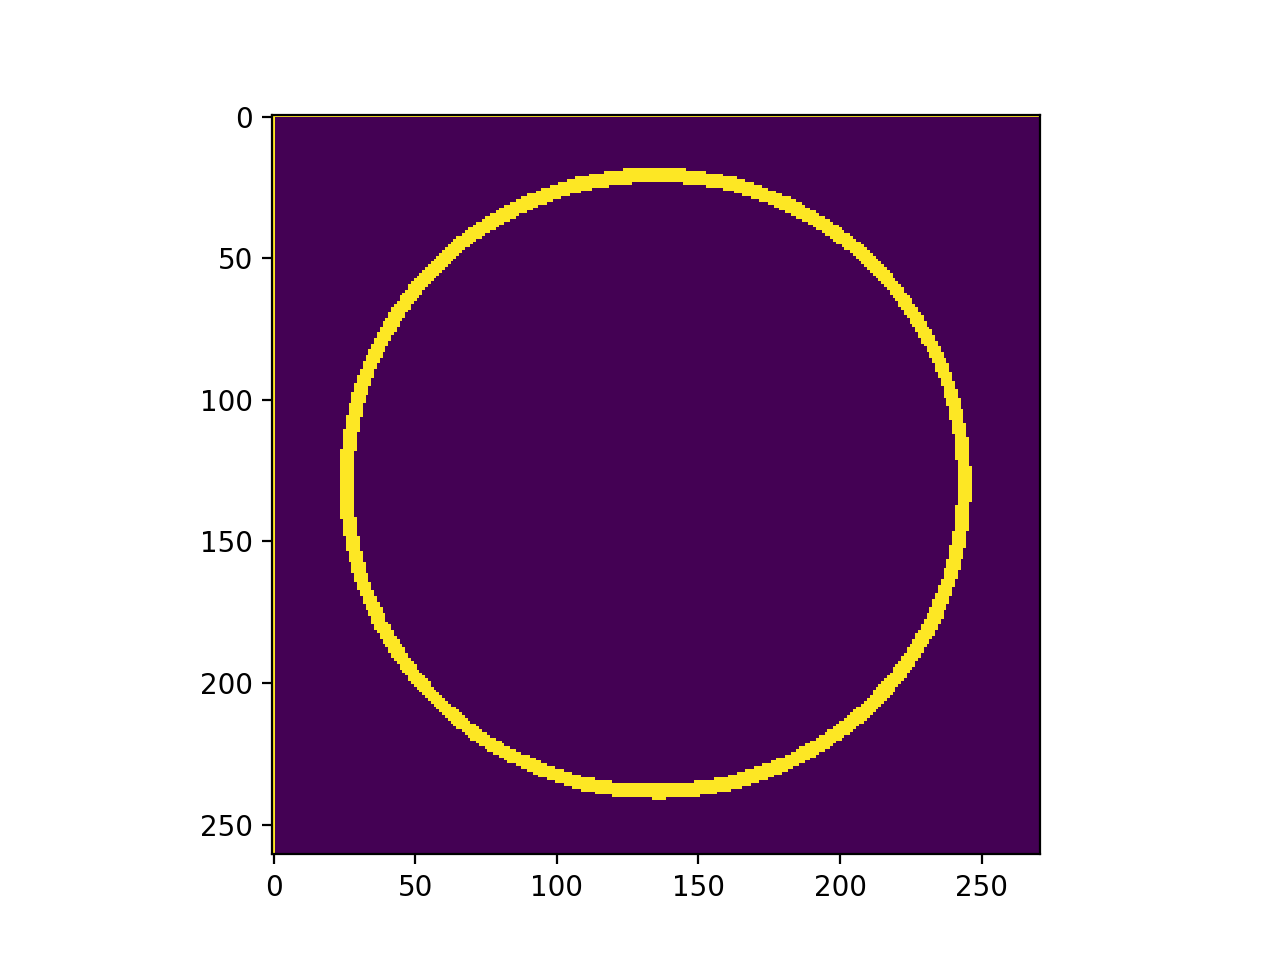

In [96]:
plt.imshow(working_sob > (working_sob.mean() * 5))

In [102]:
from skimage.transform import hough_circle, hough_circle_peaks

hough_radii = np.arange(np.floor(np.mean(working_sob.shape)/4), np.ceil(np.mean(working_sob.shape)/2), 1)
hough_res = hough_circle(working_sob > (working_sob.mean() * 5), hough_radii)

# Select the most prominent 5 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=1)

In [103]:
print(cx)
print(cy)
print(radii)

[135]
[130]
[ 108.]


<IPython.core.display.Javascript object>


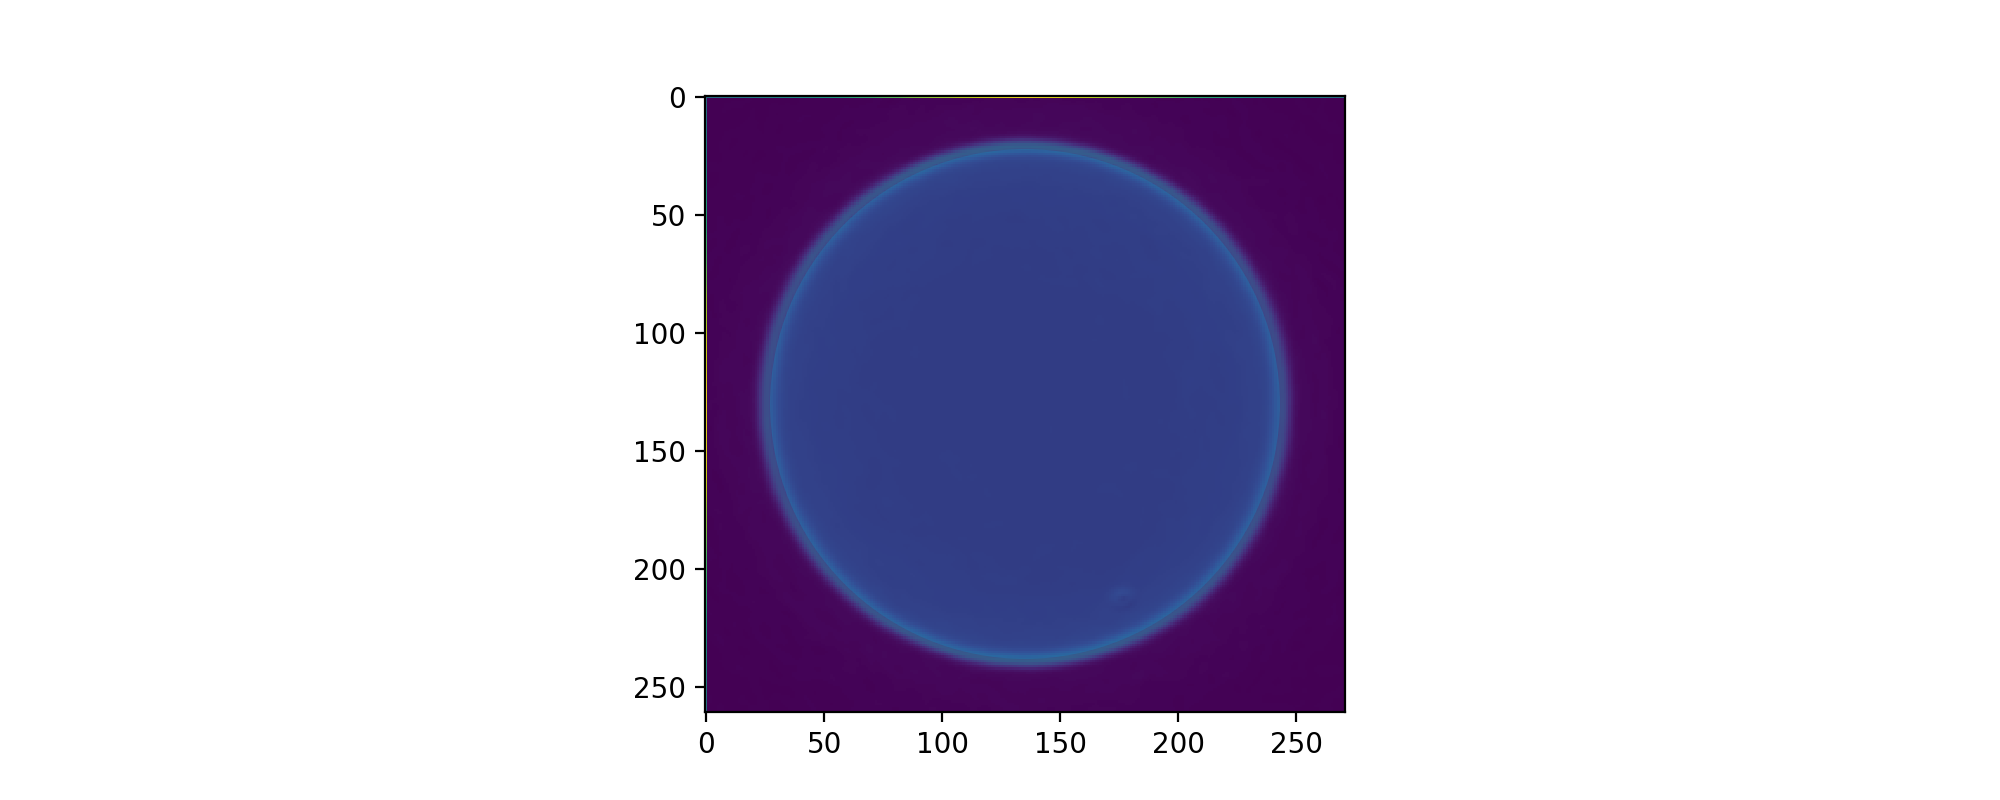

In [104]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
for xc, yc, r in zip(cx, cy, radii):
    circ = Circle([xc, yc], radius=r)
    circ.set_facecolor(None)
    circ.set_alpha(0.5)
    ax.add_artist(circ)
ax.imshow(sob[::4,::4])

In [105]:
true_radii = radii[0] * downsample_dim

In [117]:
print(true_radii)

432.0


<IPython.core.display.Javascript object>


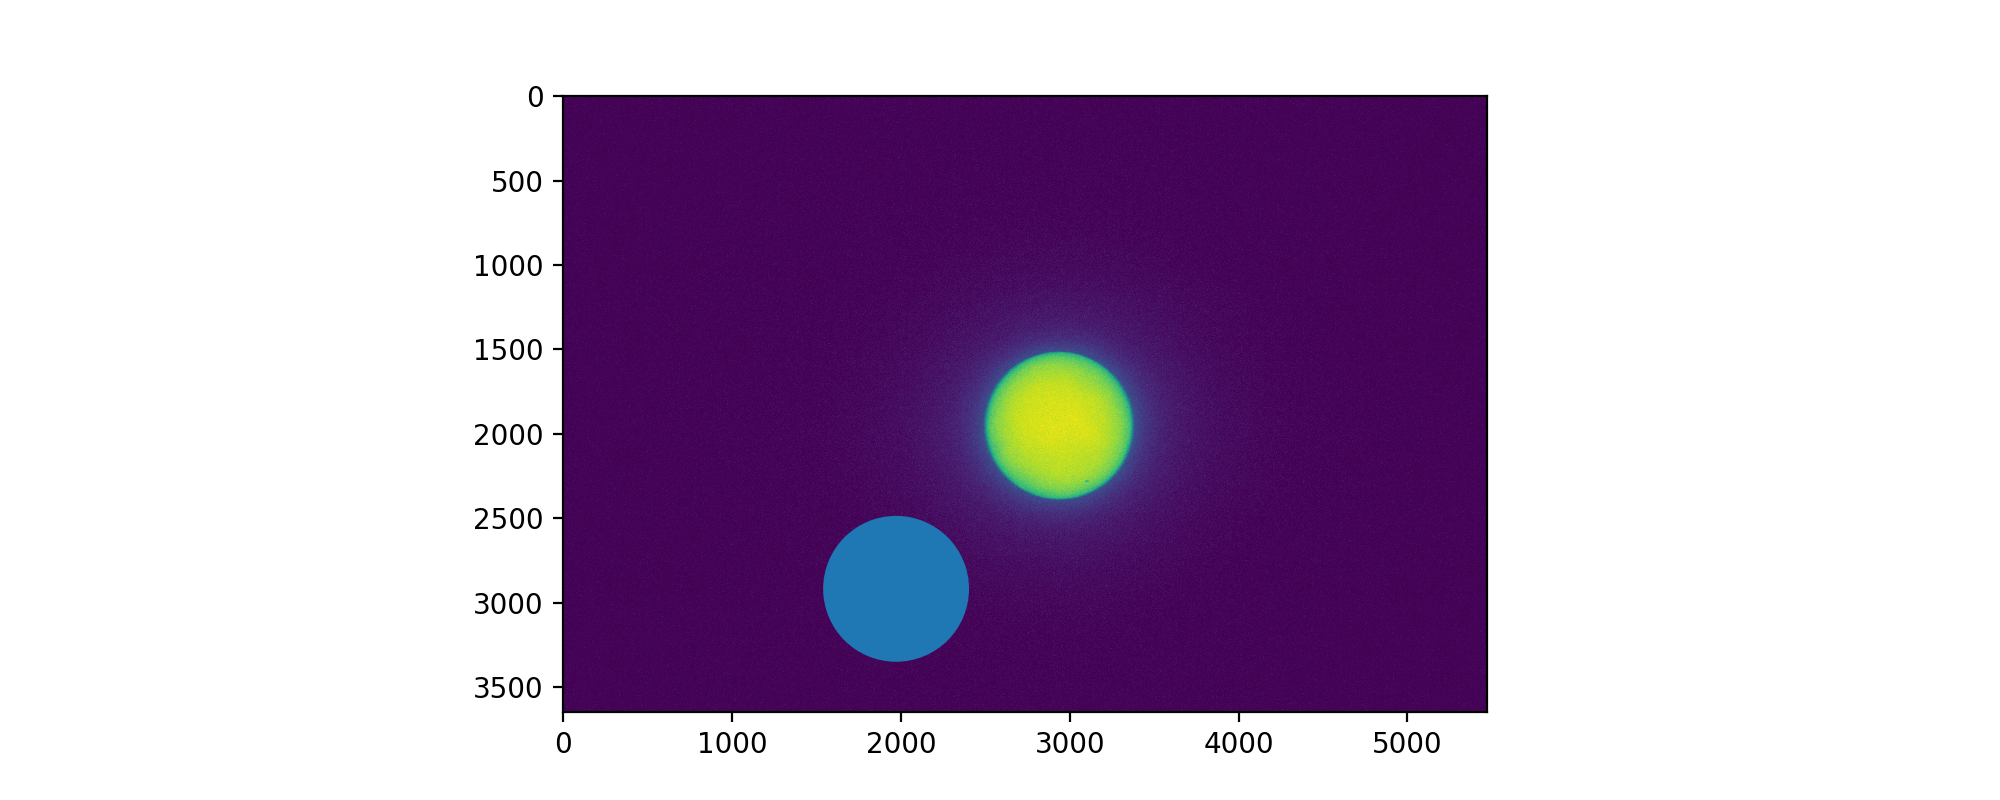

In [116]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
circ = Circle([cx[0] * downsample_dim + slice_x.start, cy[0] * downsample_dim + slice_y.start], radius=radii[0] * downsample_dim)
ax.add_artist(circ)
ax.imshow(im)


In [41]:
# Perform a Hough Transform
# The accuracy corresponds to the bin size of a major axis.
# The value is chosen in order to get a single high accumulator.
# The threshold eliminates low accumulators
result = hough_ellipse(sob[::4,::4], accuracy=20, threshold=250,
                       min_size=roi.shape[1]*0.6/4, max_size=roi.shape[1]/4)
result.sort(order='accumulator')

# Estimated parameters for the ellipse
best = list(result[-1])
yc, xc, a, b = [int(round(x)) for x in best[1:5]]
orientation = best[5]

KeyboardInterrupt: 

In [ ]:
fig2, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4), sharex=True,
                                sharey=True,
                                subplot_kw={'adjustable':'box-forced'})

ax1.set_title('Original picture')
ax1.imshow(im)

ax2.set_title('Edge (white) and result (red)')
ax2.imshow(sob)
ells = Ellipse(xy=[yc, xc], width=a, height=b, angle=orientation)
ax2.add_artist(ells)